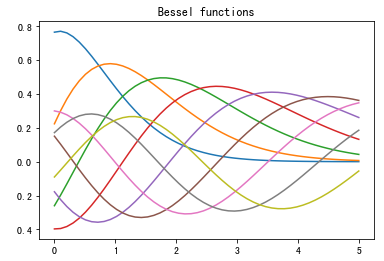

In [3]:
# 绘图案例 an example of matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn
from IPython.display import display, clear_output
import time
x = np.linspace(0,5)
f, ax = plt.subplots()
ax.set_title("Bessel functions")

for n in range(1,10):
    time.sleep(1)
    ax.plot(x, jn(x,n))
    clear_output(wait=True)
    display(f)

# close the figure at the end, so we don't get a duplicate
# of the last plot
plt.close()

# 0. 文件说明

本文件是对新人赛-快来一起挖掘幸福感！的end-to-end project思路与代码分享。这篇分享也是作者第一次参加天池竞赛，如果有在BaseLine基础上，有较好的改进，请于我联系，谢谢。
Author: pengchenghu
Date: 2019/05/22
E-mail: 15651851181@163.com


本方法是在本次比赛论坛的风5530的幸福感预测比赛-----EDA文章的基础上，增加了一些特征，最终提交成绩位0.480。在此感谢风5530的分享。

In [15]:
import os
import time 
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# 1. 认识数据

1.1 加载数据集

In [7]:
train = pd.read_csv("datalab/231702/happiness_train_complete.csv", parse_dates=["survey_time"], encoding='latin-1') 
test = pd.read_csv("datalab/231702/happiness_test_complete.csv", parse_dates=["survey_time"], encoding='latin-1')
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015-08-04 14:18:00,1,1959,1,...,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015-07-21 15:04:00,1,1992,1,...,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015-07-21 13:24:00,2,1967,1,...,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015-07-25 17:33:00,2,1943,1,...,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015-08-10 09:50:00,2,1994,1,...,2,50,50,50,50,50.0,50,50,50,50


1.2 理解数据集

In [9]:
# 查看特征的数据分布
train.describe()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.00000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000
mean,4000.50000,3.850125,1.405500,15.155375,42.564750,70.619000,1.53000,1964.707625,1.37350,0.772250,...,3.722250,70.809500,68.170000,62.737625,66.320125,62.794187,67.064000,66.09625,65.626750,67.153750
std,2309.54541,0.938228,0.491019,8.917100,27.187404,38.747503,0.49913,16.842865,1.52882,1.071459,...,1.143358,21.184742,20.549943,24.771319,22.049437,23.463162,21.586817,23.08568,23.827493,22.502203
min,1.00000,-8.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1921.000000,-8.00000,-8.000000,...,-8.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.00000,-3.000000,-3.000000
25%,2000.75000,4.000000,1.000000,7.000000,18.000000,37.000000,1.00000,1952.000000,1.00000,1.000000,...,3.000000,60.000000,60.000000,50.000000,60.000000,55.000000,60.000000,60.00000,60.000000,60.000000
50%,4000.50000,4.000000,1.000000,15.000000,42.000000,73.000000,2.00000,1965.000000,1.00000,1.000000,...,4.000000,79.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.00000,70.000000,70.000000
75%,6000.25000,4.000000,2.000000,22.000000,65.000000,104.000000,2.00000,1977.000000,1.00000,1.000000,...,5.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000
max,8000.00000,5.000000,2.000000,31.000000,89.000000,134.000000,2.00000,1997.000000,8.00000,1.000000,...,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 140 entries, id to public_service_9
dtypes: datetime64[ns](1), float64(25), int64(111), object(3)
memory usage: 8.5+ MB


In [11]:
# 查看每个特征的缺失情况
train.isnull().sum()

id                         0
happiness                  0
survey_type                0
province                   0
city                       0
county                     0
survey_time                0
gender                     0
birth                      0
nationality                0
religion                   0
religion_freq              0
edu                        0
edu_other               7997
edu_status              1120
edu_yr                  1972
income                     0
political                  0
join_party              7176
floor_area                 0
property_0                 0
property_1                 0
property_2                 0
property_3                 0
property_4                 0
property_5                 0
property_6                 0
property_7                 0
property_8                 0
property_other          7934
                        ... 
m_political                0
m_work_14                  0
status_peer                0
status_3_befor

In [12]:
# 删除训练集中无效的标签对应的数据
train = train.loc[train['happiness'] != -8]

In [13]:
train.shape

(7988, 140)

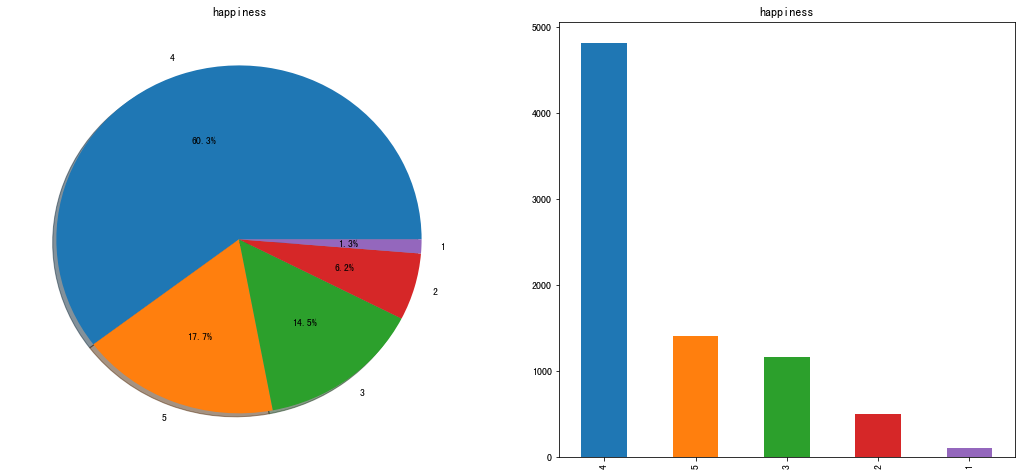

In [14]:
# 查看各个类别的分布情况，有很明显的类别不均衡的问题
f,ax=plt.subplots(1,2,figsize=(18,8))
train['happiness'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('happiness')
ax[0].set_ylabel('')
train['happiness'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('happiness')
plt.show()

Text(0.5,1,'Sex:happiness')

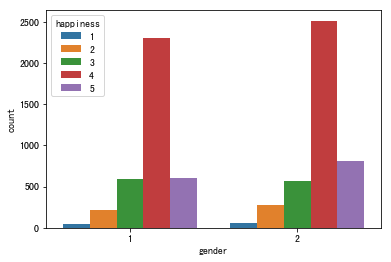

In [16]:
# 探究性别和幸福感的分布
sns.countplot('gender',hue='happiness',data=train)
ax[1].set_title('Sex:happiness')

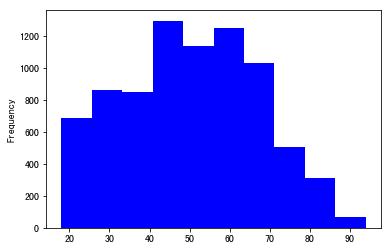

In [17]:
# 探究年龄和幸福感的关系
train['survey_time'] = train['survey_time'].dt.year
test['survey_time'] = test['survey_time'].dt.year
train['Age'] = train['survey_time']-train['birth']
test['Age'] = test['survey_time']-test['birth']
del_list=['survey_time','birth']
figure,ax = plt.subplots(1,1)
train['Age'].plot.hist(ax=ax,color='blue')

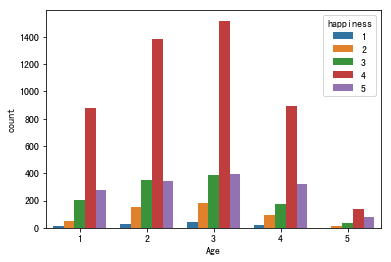

In [18]:
# 一般会将年龄分箱，避免噪声和异常值的影响
combine=[train,test]

for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 80), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 80, 'Age'] = 5
sns.countplot('Age', hue='happiness', data=train)

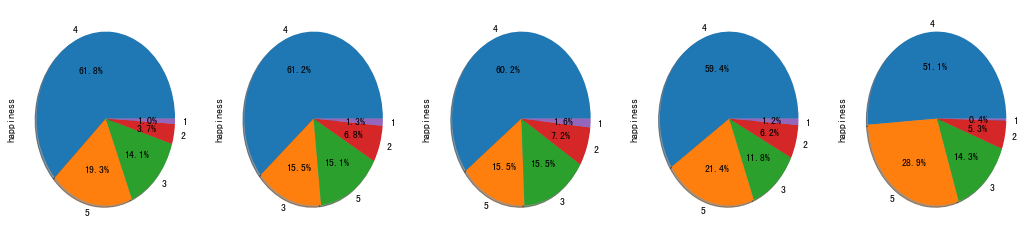

In [21]:
figure1,ax1 = plt.subplots(1,5,figsize=(18,4))
train['happiness'][train['Age']==1].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[0],shadow=True)
train['happiness'][train['Age']==2].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[1],shadow=True)
train['happiness'][train['Age']==3].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[2],shadow=True)
train['happiness'][train['Age']==4].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[3],shadow=True)
train['happiness'][train['Age']==5].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[4],shadow=True)

1.3 特征选择

In [22]:
# 目前只考虑通过相关性选择特征
train.corr()['happiness'][abs(train.corr()['happiness'])>0.05]

happiness               1.000000
edu                     0.103048
edu_yr                  0.055564
political               0.080986
join_party              0.069007
property_8             -0.051929
weight_jin              0.085841
health                  0.250538
health_problem          0.186620
depression              0.304973
hukou                   0.072936
media_1                 0.095035
media_2                 0.084872
media_3                 0.091431
media_4                 0.098809
media_5                 0.065220
media_6                 0.059273
leisure_1              -0.077097
leisure_3              -0.070262
leisure_4              -0.095676
leisure_6              -0.107672
leisure_7              -0.072011
leisure_8              -0.100313
leisure_9              -0.148888
leisure_12             -0.068778
socialize               0.082206
relax                   0.113233
learn                   0.108294
social_friend          -0.091079
socia_outing            0.059567
          

In [23]:
# 选择相关性大于0.05的作为候选特征参与训练，并加入我们认为比较重要的特征，总共66个特征参与训练
features = (train.corr()['happiness'][abs(train.corr()['happiness'])>0.05]).index
features = features.values.tolist()
features.extend(['Age', 'work_exper'])
features.remove('happiness')
len(features)

66

# 2. 模型搭建

2.1 基本模型（这里的参数我参照上文提到的模型参数，不一定是最合适的，需要读者自行调整）

In [24]:
# 生成数据和标签
target = train['happiness']
train_selected = train[features]
test = test[features]
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [25]:
params = {'num_leaves': 9,
         'min_data_in_leaf': 40,
         'objective': 'regression',
         'max_depth': 16,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,   # 每次迭代时用的数据比例
         'feature_fraction': 0.8201,# 每次迭代中随机选择80％的参数来建树
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'rmse',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [26]:
kfolds = KFold(n_splits=5,shuffle=True,random_state=15)
predictions = np.zeros(len(test))

for fold_n,(trn_index,val_index) in enumerate(kfolds.split(train_selected,target)):
    print("fold_n {}".format(fold_n))
    trn_data = lgb.Dataset(train_selected.iloc[trn_index],label=target.iloc[trn_index])
    val_data = lgb.Dataset(train_selected.iloc[val_index],label=target.iloc[val_index])
    num_round=10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_index] = clf.predict(train_selected.iloc[val_index], num_iteration=clf.best_iteration)
    predictions += clf.predict(test,num_iteration=clf.best_iteration)/5
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print("CV score: {:<8.5f}".format(mean_squared_error(target, oof)**0.5))

fold_n 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[835]	training's rmse: 0.631985	valid_1's rmse: 0.681313
CV score: 3.54967 
fold_n 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.618499	valid_1's rmse: 0.691913
Early stopping, best iteration is:
[1035]	training's rmse: 0.616785	valid_1's rmse: 0.691461
CV score: 3.10335 
fold_n 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.629692	valid_1's rmse: 0.649479
Early stopping, best iteration is:
[1545]	training's rmse: 0.605341	valid_1's rmse: 0.64739
CV score: 2.55891 
fold_n 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[865]	training's rmse: 0.62686	valid_1's rmse: 0.699352
CV score: 1.87169 
fold_n 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 0.62042	valid_1's rmse: 0.685821
Early stopping, best it

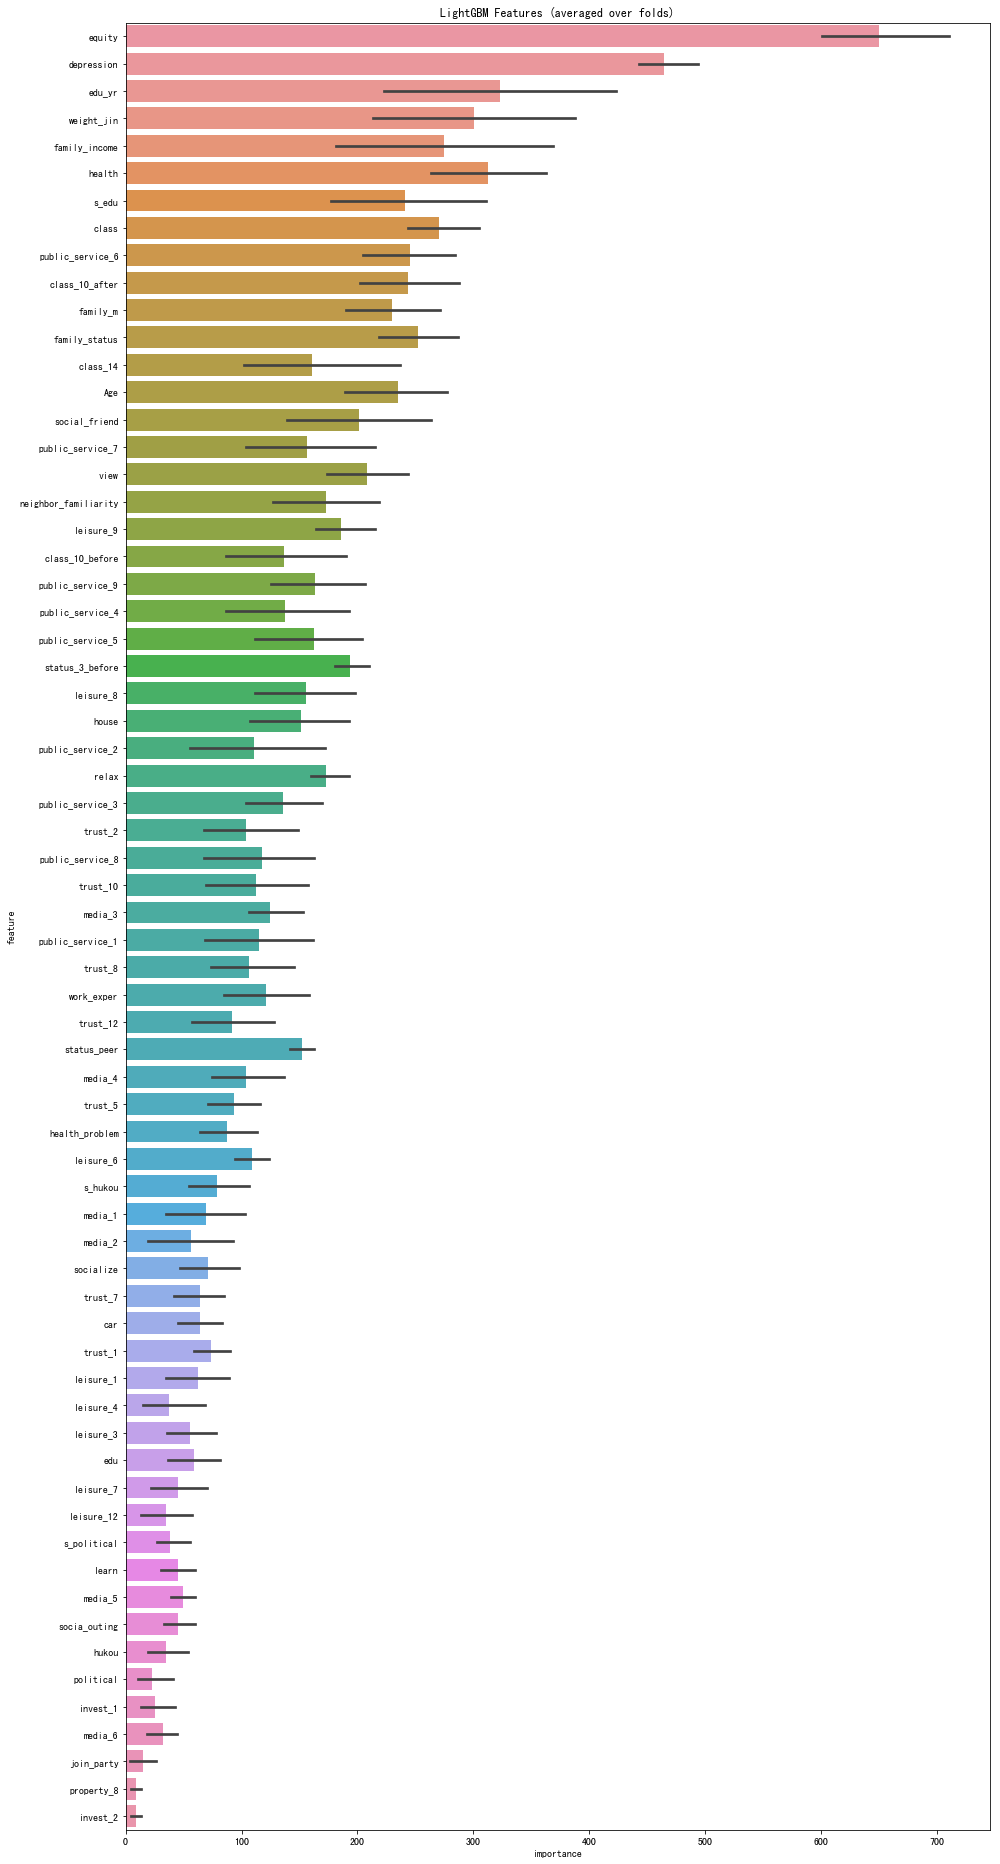

In [27]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [29]:
# 计算结果
submit = pd.read_csv("datalab/231702/happiness_submit.csv")
submision_lgb1  = pd.DataFrame({"id":submit['id'].values})
submision_lgb1["happiness"]=predictions
submision_lgb1.head(5)

,id,happiness
0,8001,3.808610
1,8002,2.983029
2,8003,3.375671
3,8004,4.277889
4,8005,3.300427


2.2 模型调参（略）

# 3. 结果文件生成

In [31]:
# 获取时间
time_str = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
out_dir = "/home/tianchi/myspace/happiness/lgbm/{}/".format(time_str)
os.makedirs(out_dir)

# 保存模型
clf.save_model(out_dir + "model.txt")
# 保存结果
submision_lgb1.to_csv(out_dir + "submision_lgbm.csv",index=False)
